In [1]:
import copy
import torch
import torch.nn
import matplotlib
import numpy as np
import loss_landscapes
import torch.optim as optim
import loss_landscapes.metrics
from loss_landscapes import GeneralModelWrapper
import torch.nn.functional as F
import torchvision.datasets as datasets
from tqdm import tqdm
from ExplanationEvaluation.tasks.quick import *
from ExplanationEvaluation.datasets.dataset_loaders import load_dataset
from ExplanationEvaluation.models.GNN_paper import NodeGCN as GNN_NodeGCN
torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda', index=1)
#device = "cpu"

In [2]:
from pylab import rcParams
from palettable.colorbrewer.qualitative import Paired_6, Set2_6, Set2_4
from palettable.cartocolors.sequential import SunsetDark_6, agGrnYl_6, TealGrn_6, Mint_6, SunsetDark_3, agGrnYl_4
from matplotlib import gridspec
import matplotlib

import matplotlib.pyplot as plt

params = {
   'axes.labelsize': 16,
   'font.family': 'Times New Roman',
   'font.size': 15,
   'legend.fontsize': 15,
   'xtick.labelsize': 15,
   'ytick.labelsize': 15,
   'text.usetex': False,
   'figure.figsize': [4*1.5, 3*1.5]
   }

rcParams.update(params)
matplotlib.rc('pdf', fonttype=42)
matplotlib.font_manager._rebuild()


def process_stats(l, log=False):
    report={}
    elem = np.vstack(l)
    if log:
        elem= np.log(elem)
    report[f'loss'] = np.mean(elem, axis=0)
    report[f'loss_std'] = np.std(elem, axis=0)
    return report


def process_stats_v2(l1, l2, log=False):
    report={}
    elem1 = np.vstack(l1)
    elem2 = np.vstack(l2)
    
    elem =  1- elem1 / elem2
    if log:
        elem= np.log(elem)
    report[f'loss'] = np.mean(elem, axis=0)
    report[f'loss_std'] = np.std(elem, axis=0)
    return report

#def add_loss_plot(ax,report,label, key, color,marker=None, markersize=None, markevery=100,linestyle='-',std=True, alpha=1):
#    ax.plot([1/STEPS * i for i in range(STEPS)], report[key], color=color, label=label,marker=marker, markersize=markersize, markevery=markevery,linestyle=linestyle, alpha=alpha)
#    if std:
#        ax.fill_between([1/STEPS * i for i in range(STEPS)],
#                    (report[key]+report[f'{key}_std']).flatten(),
#                    (report[key]-report[f'{key}_std']).flatten(),color=color, alpha=0.2)
        
def add_loss_plot_v2(ax,report,label, key, color,marker=None, markersize=None, markevery=100,linestyle='-',std=True, alpha=1):
    ax.plot(range(report[key].shape[0]), report[key], color=color, label=label,marker=marker, markersize=markersize, markevery=markevery,linestyle=linestyle, alpha=alpha)
    if std:
        ax.fill_between(range(report[key].shape[0]),
                    (report[key]+report[f'{key}_std']).flatten(),
                    (report[key]-report[f'{key}_std']).flatten(),color=color, alpha=0.2)
        
def add_perc_plot_v2(ax,report,label, key, color,marker=None, markersize=None, markevery=100,linestyle='-',std=True, alpha=1):
    ax.plot(range(report[key].shape[0]), report[key], color=color, label=label,marker=marker, markersize=markersize, markevery=markevery,linestyle=linestyle, alpha=alpha)
    if std:
        ax.fill_between(range(report[key].shape[0]),
                    (report[key]+report[f'{key}_std']).flatten(),
                    (report[key]-report[f'{key}_std']).flatten(),color=color, alpha=0.2)

In [3]:
dataset = "syn3"
if dataset == "syn1":
    r = range(400, 700, 10)
    gnn1 = GNN_NodeGCN(10, 4)
    gnn2 = GNN_NodeGCN(10, 4)
elif dataset == "syn2":
    r = range(400, 700, 10)
    gnn1 = GNN_NodeGCN(10, 8)
    gnn2 = GNN_NodeGCN(10, 8)
elif dataset == "syn3":
    r = range(511, 871, 12)
    gnn1 = GNN_NodeGCN(10, 2)
    gnn2 = GNN_NodeGCN(10, 2)
else:
    r = range(511, 800, 4)
    gnn1 = GNN_NodeGCN(10, 2)
    gnn2 = GNN_NodeGCN(10, 2)
    
graphs, features, labels, train_mask, val_mask, test_mask  = load_dataset(dataset)
features = torch.tensor(features).to(device)
labels = torch.tensor(labels).to(device)
graphs = torch.tensor(graphs).to(device)
gnn1 = gnn1.to(device)
gnn2 = gnn2.to(device)

Loading syn3 dataset


In [4]:
import time

start = time.time()
gnn1 = train_node(gnn1, dataset, graphs, features, labels, train_mask, val_mask, test_mask)
end = time.time()
print(end - start)

Epoch: 0, train_acc: 0.4181, val_acc: 0.3908, train_loss: 0.7070
Epoch: 1, train_acc: 0.4181, val_acc: 0.3908, train_loss: 0.6991
Epoch: 2, train_acc: 0.5819, val_acc: 0.6092, train_loss: 0.6936
Epoch: 3, train_acc: 0.5819, val_acc: 0.6092, train_loss: 0.6895
Epoch: 4, train_acc: 0.5819, val_acc: 0.6092, train_loss: 0.6867
Epoch: 5, train_acc: 0.5819, val_acc: 0.6092, train_loss: 0.6844
Epoch: 6, train_acc: 0.5819, val_acc: 0.6092, train_loss: 0.6825
Epoch: 7, train_acc: 0.5819, val_acc: 0.6092, train_loss: 0.6809
Epoch: 8, train_acc: 0.5819, val_acc: 0.6092, train_loss: 0.6798
Epoch: 9, train_acc: 0.5819, val_acc: 0.6092, train_loss: 0.6791
Epoch: 10, train_acc: 0.5819, val_acc: 0.6092, train_loss: 0.6788
Epoch: 11, train_acc: 0.5819, val_acc: 0.6092, train_loss: 0.6790
Epoch: 12, train_acc: 0.5819, val_acc: 0.6092, train_loss: 0.6793
Epoch: 13, train_acc: 0.5819, val_acc: 0.6092, train_loss: 0.6799
Epoch: 14, train_acc: 0.5819, val_acc: 0.6092, train_loss: 0.6802
Epoch: 15, train_acc

In [5]:
start = time.time()
gnn2 = meta_train_node(gnn2, dataset, graphs, features, labels, train_mask, val_mask, test_mask)
end = time.time()
print(end - start)

Epoch: 0, train_acc: 0.5819, val_acc: 0.6092, train_loss: 0.6862
Epoch: 1, train_acc: 0.5819, val_acc: 0.6092, train_loss: 0.6809
Epoch: 2, train_acc: 0.5819, val_acc: 0.6092, train_loss: 0.6793
Epoch: 3, train_acc: 0.5819, val_acc: 0.6092, train_loss: 0.6800
Epoch: 4, train_acc: 0.5819, val_acc: 0.6092, train_loss: 0.6810
Epoch: 5, train_acc: 0.5819, val_acc: 0.6092, train_loss: 0.6814
Epoch: 6, train_acc: 0.5819, val_acc: 0.6092, train_loss: 0.6810
Epoch: 7, train_acc: 0.5819, val_acc: 0.6092, train_loss: 0.6803
Epoch: 8, train_acc: 0.5819, val_acc: 0.6092, train_loss: 0.6797
Epoch: 9, train_acc: 0.5819, val_acc: 0.6092, train_loss: 0.6792
Epoch: 10, train_acc: 0.5819, val_acc: 0.6092, train_loss: 0.6789
Epoch: 11, train_acc: 0.5819, val_acc: 0.6092, train_loss: 0.6788
Epoch: 12, train_acc: 0.5819, val_acc: 0.6092, train_loss: 0.6788
Epoch: 13, train_acc: 0.5819, val_acc: 0.6092, train_loss: 0.6789
Epoch: 14, train_acc: 0.5819, val_acc: 0.6092, train_loss: 0.6788
Epoch: 15, train_acc

In [ ]:
l1s = []
l2s = []
for i in r:
    explainer1 = GNNExplainer(gnn1, graphs, features, i)
    _, _, l1 = explainer1.explain()
    l1s.append(l1)
    explainer2 = GNNExplainer(gnn2, graphs, features, i)
    _, _, l2 = explainer2.explain()
    l2s.append(l2)

In [ ]:
std_loss = process_stats(l1s)
mate_loss = process_stats(l2s)

In [8]:
#import pickle

#with open("l2syn3", "wb") as fp: 
#    pickle.dump(l2s, fp)

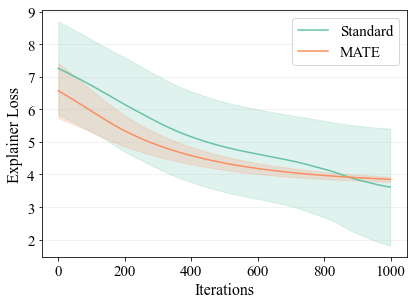

In [9]:
colors = Set2_6.mpl_colors
fig, ax = plt.subplots(1)
item = 'loss'
add_loss_plot_v2(ax, std_loss, 'Standard', item, colors[0])
add_loss_plot_v2(ax, mate_loss, 'MATE', item, colors[1])
ax.yaxis.grid(linewidth=0.5, alpha=0.3)
ax.legend()
ax.set_ylabel("Explainer Loss")
ax.set_xlabel("Iterations")
plt.tight_layout()
plt.show()
fig.savefig('plot.pdf', bbox_inches='tight', pad_inches=0)

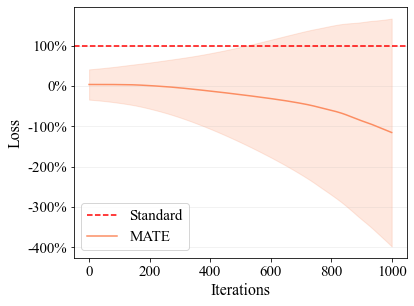

In [10]:
colors = Set2_6.mpl_colors
fig, ax = plt.subplots(1)
item = 'loss'
import matplotlib.ticker as mtick
from matplotlib.ticker import FuncFormatter
report = process_stats_v2(l2s, l1s)
#add_loss_plot_v2(ax, std_loss, 'Standard', item, colors[0])
plt.axhline(y = 1,label='Standard', color = 'r', linestyle = 'dashed') 
add_loss_plot_v2(ax, report, 'MATE', item, colors[1])
#ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax.yaxis.grid(linewidth=0.5, alpha=0.3)
ax.legend()
ax.set_ylabel("Loss")
ax.set_xlabel("Iterations")
plt.tight_layout()
plt.show()
fig.savefig('plot.pdf', bbox_inches='tight', pad_inches=0)

In [11]:
1 - np.asarray(mate_loss['loss']) / np.asarray(std_loss['loss']) 

array([ 9.46707748e-02,  9.48808479e-02,  9.50906623e-02,  9.53009252e-02,
        9.55115797e-02,  9.57226342e-02,  9.59335626e-02,  9.61440811e-02,
        9.63549481e-02,  9.65663315e-02,  9.67781744e-02,  9.69905999e-02,
        9.72037562e-02,  9.74172991e-02,  9.76312466e-02,  9.78458856e-02,
        9.80610373e-02,  9.82769238e-02,  9.84933646e-02,  9.87103361e-02,
        9.89276737e-02,  9.91455054e-02,  9.93636912e-02,  9.95822229e-02,
        9.98011611e-02,  1.00020575e-01,  1.00240670e-01,  1.00461312e-01,
        1.00682497e-01,  1.00903865e-01,  1.01125729e-01,  1.01347954e-01,
        1.01570453e-01,  1.01793119e-01,  1.02016063e-01,  1.02238942e-01,
        1.02461917e-01,  1.02685124e-01,  1.02908528e-01,  1.03131980e-01,
        1.03355251e-01,  1.03578428e-01,  1.03801313e-01,  1.04024213e-01,
        1.04246968e-01,  1.04469743e-01,  1.04692474e-01,  1.04915048e-01,
        1.05137609e-01,  1.05360463e-01,  1.05583268e-01,  1.05806317e-01,
        1.06029632e-01,  

In [12]:
std_loss = process_stats(l1s, True)
mate_loss = process_stats(l2s, True)

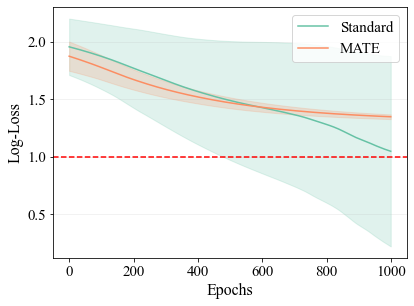

In [13]:
colors = Set2_6.mpl_colors
fig, ax = plt.subplots(1)
item = 'loss'
add_loss_plot_v2(ax, std_loss, 'Standard', item, colors[0])
plt.axhline(y = 1, color = 'r', linestyle = 'dashed')
add_loss_plot_v2(ax, mate_loss, 'MATE', item, colors[1])
ax.yaxis.grid(linewidth=0.5, alpha=0.3)
ax.legend()
ax.set_ylabel("Log-Loss")
ax.set_xlabel("Epochs")
plt.tight_layout()
plt.show()
fig.savefig('plotlog.pdf', bbox_inches='tight', pad_inches=0)

In [14]:
#STEPS = 200 # contour plot resolution
#ID = 530

In [15]:
#explainer1 = GNNExplainer(gnn1, graphs, features, ID)
#explainer_initial1 = copy.deepcopy(explainer1)
#explainer_initial1.predict()
#del explainer_initial1.model_to_explain

In [16]:
#explainer2 = GNNExplainer(gnn2, graphs, features, ID)
#explainer_initial2 = copy.deepcopy(explainer2)
#explainer_initial2.predict()
#del explainer_initial2.model_to_explain

In [17]:
#metric1 = loss_landscapes.metrics.Loss(explainer_initial1._loss, gnn1, explainer_initial1.pred_label.unsqueeze(0))
#metric2 = loss_landscapes.metrics.Loss(explainer_initial2._loss, gnn2, explainer_initial2.pred_label.unsqueeze(0))

In [18]:
#loss_data_fin1 = loss_landscapes.random_plane(explainer_initial1, metric1, 0.1, STEPS, deepcopy_model=True)
#loss_data_fin2 = loss_landscapes.random_plane(explainer_initial2, metric2, 0.1, STEPS, deepcopy_model=True)

In [19]:
#constrained_layout=True
#fig = plt.figure(constrained_layout=True)
#axes = fig.subplots(nrows=1, ncols=2, sharey=True)
#i = 0
#for ax in axes:
#    if i == 0:
#        ax.contour(loss_data_fin1, 20, colors='black', alpha=0.5)
#        im = ax.imshow(loss_data_fin1, cmap='RdGy', alpha=0.5)
#        i+=1
#    else:
#        ax.contour(loss_data_fin2, 20, colors='black', alpha=0.5)
#        im = ax.imshow(loss_data_fin2, cmap='RdGy', alpha=0.5)
#fig.colorbar(im, ax=axes, location='bottom')


In [20]:
#std_inter = process_stats(i1s)
#mate_inter = process_stats(i2s)

#i1s = []
#i2s = []
#l1s = []
#l2s = []
#for i in r:
#    explainer1 = GNNExplainer(gnn1, graphs, features, i)
    #explainer_initial1 = copy.deepcopy(explainer1)
    #explainer_initial1.predict()
#    _, _, l1 = explainer1.explain()
#    l1s.append(l1)
    #del explainer1.model_to_explain
    #del explainer_initial1.model_to_explain
    #metric1 = loss_landscapes.metrics.Loss(explainer_initial1._loss, gnn1, explainer_initial1.pred_label.unsqueeze(0))
    #i1s.append(loss_landscapes.linear_interpolation(explainer_initial1, explainer1, metric1, STEPS, deepcopy_model=True))

#    explainer2 = GNNExplainer(gnn2, graphs, features, i)
    #explainer_initial2 = copy.deepcopy(explainer2)
    #explainer_initial2.predict()
#    _, _, l2 = explainer2.explain()
#    l2s.append(l2)
    #del explainer2.model_to_explain
    #del explainer_initial2.model_to_explain
    #metric2 = loss_landscapes.metrics.Loss(explainer_initial2._loss, gnn2, explainer_initial2.pred_label.unsqueeze(0))
    #i2s.append(loss_landscapes.linear_interpolation(explainer_initial2, explainer2, metric2, STEPS, deepcopy_model=True))

#colors = Set2_6.mpl_colors
#fig, ax = plt.subplots(1)
#item = 'loss'
#add_loss_plot(ax, std_inter, 'Standard', item, colors[0])
#add_loss_plot(ax, mate_inter, 'MATE', item, colors[1])
#ax.yaxis.grid(color="0.4", linewidth=0.5) 
#ax.legend()
#plt.xlabel('Interpolation Coefficient')
#plt.ylabel('Loss')
#plt.tight_layout()
#plt.show()
#fig.savefig('plot.pdf', bbox_inches='tight', pad_inches=0)

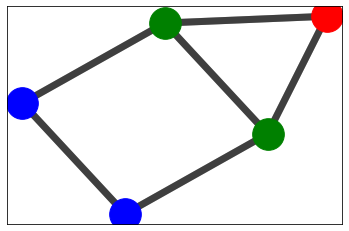

In [5]:
from ExplanationEvaluation.utils.plotting import plot_house
import numpy as np
np.random.seed(19)
plot_house()